<a href="https://www.kaggle.com/code/iamamir/email-spam-detection-using-nlp-and-svm?scriptVersionId=120072927" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/spam-email/spam.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Scenario
Company dislikeSpam approaches us to improve their customer service by allowing their customers to reach out to them with text messages. However, since they are afraid that they will receive a lot of spam messages, they would like to recognize and filter them automatically. Our task is to build a first prototype and create a proof of concept.

![](http://www.dww.com/sites/default/files/styles/landscape_ri/public/shutterstock_172545959.jpg?itok=mPrJKywC)

Image source: http://www.dww.com/sites/default/files/styles/landscape_ri/public/shutterstock_172545959.jpg?itok=mPrJKywC

# Understand Data

In [2]:
#Import regured modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.6f}'.format

# Read Data
df = pd.read_csv('/kaggle/input/spam-email/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Note:
What is ham and spam?
"Ham" is e-mail that is not Spam. In other words, "non-spam", or "good mail". It should be considered a shorter, snappier synonym for "non-spam". Its usage is particularly common among anti-spam software developers, and not widely known elsewhere; in general it is probably better to use the term "non-spam", instead.

[source](https://cwiki.apache.org/confluence/display/spamassassin/Ham#:~:text=%22Ham%22%20is%20e%2Dmail,non%2Dspam%22%2C%20instead.)

In [3]:
# DataFrame shape - Number of rows and columns
df.shape

(5572, 2)

In [4]:
# Take a look at two example of not-spam and spam message
print('Example of not-spam message: ', df.loc[0, 'Message'])
print('Example of spam message: ', df.loc[2, 'Message'])

Example of not-spam message:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Example of spam message:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


# Data Cleaning and Prepration
In this step, first, the text data is going to be cleaned to correct errors and give it more structure for analysis (data cleaning and preparation). Then[ NLP methods](https://www.ibm.com/topics/natural-language-processing#:~:text=the%20next%20step-,What%20is%20natural%20language%20processing%3F,same%20way%20human%20beings%20can.) are used to get certain parts of the text that reflect the categories as best as possible. These extracted features can then be used with classification models. In this project, [Support Vector Machine](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) is going to be used as classifer.

In [5]:
#  Add new column Spam to DataFrame to which shows which message is spam and which one is ham by replacing spam/ham 
# by 1/0 respectively.
df['Spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.head(5)

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# Import required modules for playing with strings
import string
import re

# NLP modules
import spacy
import nltk

In [7]:
#  Load spacy's English statistical model to enable NLP tasks for an English corpus
from spacy.lang.en.examples import sentences
nlp = spacy.load('en_core_web_sm')
print(type(nlp))

<class 'spacy.lang.en.English'>


We see that nlp has the data type Language. This means that it contains all the components necessary to process English-language text. For more details please see [here](https://spacy.io/usage/models).

### Cleaning And Processing Techniques are:
[Useful links:](https://www.turing.com/kb/natural-language-processing-function-in-ai)
#### Tokenization
In order to properly analyze text data, machine learning models should be able to recognize structures in the text, such as individual words and their parts of speech. We achieve this through tokenization. The corpus is broken down into meaningful linguistic units, such as words or sentences, and saved as a list. The elements of this list are called tokens. 

#### Lemmatization
Lemmatization means that words are reduced to their basic form, also known as lemma. For grammatical reasons, different forms of the same word can be used in one text, e.g. make, makes, making or maker. Python would consider these variations of the word make as separate words, even though their meaning is the same. Through lemmatization, we bring all variations of make to this basic form.
#### Stop word removal
Stop word removal is used to remove common words from a text. Stop words are usually articles ("the" and "a"), pronouns like "I" and "you" , or common verbs ("be", "can"). These words are common in most English language texts. Removing these words would reduce the amount of data that needs to be analyzed while allowing machine learning algorithms to place more weight on tokens that give a text its real meaning.

In [8]:
# Import stopwords from nltk
from nltk.corpus import stopwords

# Save stopwords as a set
stopWords = set(stopwords.words('english'))
type(stopWords)
print(stopWords)

{'after', 'didn', 'being', 'doing', 'itself', 'did', "needn't", 'it', "it's", 'between', 'at', 'up', 'their', 'with', 'on', 'mightn', 'will', 'if', "shouldn't", 'but', 'from', 'very', "you'll", "doesn't", 'won', 'should', 'she', 'where', 'for', 'ourselves', 'over', 'they', "you'd", 'he', 'i', 'himself', "mustn't", 'how', 'once', 'theirs', 'his', 'both', "weren't", 'does', 'so', 'having', 'been', 'him', 'such', 's', 'shouldn', "wouldn't", "haven't", 'of', 'no', 'couldn', 'then', 'all', "don't", 'now', 'other', 'aren', 'that', 'to', 'were', 'her', 'was', 'yours', 'by', 'when', 'own', 'out', 'just', "you're", 't', 'can', 'about', 'while', 'more', 'who', 'in', 'as', 'only', 'we', 're', 'some', 'an', 'has', 'do', "should've", 've', 'most', 'hers', 'is', 'few', 'are', "she's", 'd', 'same', 'm', 'nor', 'why', 'through', 'there', 'had', 'isn', 'be', 'yourselves', 'needn', 'against', 'y', 'have', 'during', "shan't", "you've", 'further', "didn't", 'll', "isn't", 'wasn', 'wouldn', 'before', 'thos

#### Removal of Punctuation Marks
Just like stop word removal, punctuation removal involves removing punctuation marks and symbols that do not contribute to the meaning of the text. We can use punctuation from the string module. This is a string consisting of punctuation marks and symbols. We can remove these from our text like the stop words.

In [9]:
# List of punctuation marks
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Steps explained above are all packed into function message_cleaner is going to be used for cleaninf and processing of our text data. 

In [10]:
# `Function message_cleaner
def message_cleaner(sentence):
    """
    Function message_cleaner clean the text using typical Natural Language Processing
    (NLP) steps. 
    Steps include: Lemmatization, removing stop words, removing punctuations  
    Args:
        sentence (str): The uncleaned text. 
    Returns:
        str: The cleaned text.
    """
    # Create the Doc object named `text` from `sentence` using `nlp()`
    text = nlp(sentence)    
    # Lemmatization - remove the lemmas -PRON-     
    text = [ token.lemma_ for token in text if token.lemma_ != "-PRON-"]
    # Remove stop words
    text = [ token for token in text if token not in stopWords ]
    # Remove punctuations
    text = [ token for token in text if token not in punctuations]
    # Use the .join() method on text to convert string
    text = " ".join(text)
    # Use re.sub() to substitute multiple spaces or dots`[\.\s]+` to single space `' '`
    text  = re.sub('[\.\s]+', ' ', text)
    
    # Return the cleaned text
    return text

Now it's time to apply our function to all messages in df.  

In [11]:
# Apply function message_cleaner to all text messages and store the results in new column as message_cleaned
df.loc[:,'message_cleaned'] = df.loc[:,'Message'].apply(message_cleaner)

In [12]:
# Display the results
df

,Category,Message,Spam,message_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah I think go usf live around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,2nd time try 2 contact u u win £ 750 Pound pri...
5568,ham,Will ü b going to esplanade fr home?,0,ü b go esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood suggestion
5570,ham,The guy did some bitching but I acted like i'd...,0,guy bitching I act like I would interested buy...


# Vectorization of Texts
Now all text messages are cleaned and prepared. We can now start with the vectorization.
Because we only have one dataset for this exercise, we can train our model, but we can't test it on a different dataset. The function train_test_split() provides us with the necessary tool for this . train_test_split() splits the dataset into a training dataset and a test dataset.

In [13]:
from sklearn.model_selection import train_test_split

# Define feature and target 
features = df.loc[:, 'message_cleaned']
target = df.loc[:, 'Spam']

# Determine train and test feature and target 
# 30% of features are thus assigned to the test data set
# Set the value 1 for random_state (to make our results reproducible)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.3, 
                                                                            random_state = 1)

# The Bag of Words Method
A[ bag of words](https://www.mygreatlearning.com/blog/bag-of-words/#:~:text=to%20do%20so.-,What%20is%20a%20Bag%20of%20Words%20in%20NLP%3F,-Bag%20of%20words) is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

To apply BoW vectorization, we use the transformer CountVectorizer from sklearn.feature_extraction.text ([link to documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer()
count_vectorizer = CountVectorizer()

# Fit count_vectorizer to features_train and transform them
features_train_bow = count_vectorizer.fit_transform(features_train)

# In order to store these efficiently in memory, there is the data type .csr_matrix
type(features_train_bow)

scipy.sparse.csr.csr_matrix

In [15]:
# Number of features in features_train_bow 
bow_features = count_vectorizer.get_feature_names() 
len(bow_features)

6320

In [16]:
# Take a look at features_train_bow
bow_array = features_train_bow.toarray()
bow_vector = pd.DataFrame(bow_array, columns=bow_features)
display(bow_vector.head(), bow_vector.shape)

00  000  008704050406  0121  01223585236  01223585334  0125698789  02  \
0   0    0             0     0            0            0           0   0   
1   0    0             0     0            0            0           0   0   
2   0    0             0     0            0            0           0   0   
3   0    0             0     0            0            0           0   0   
4   0    0             0     0            0            0           0   0   

   0207  02072069400  02073162414  02085076972  021  03  04  0430  05  050703  \
0     0            0            0            0    0   0   0     0   0       0   
1     0            0            0            0    0   0   0     0   0       0   
2     0            0            0            0    0   0   0     0   0       0   
3     0            0            0            0    0   0   0     0   0       0   
4     0            0            0            0    0   0   0     0   0       0   

   0578  06  07  07008009200  07090201529  07123456789  07732584351  \
0     0   0   0            0            0            0            0   
1     0   0   0            0            0            0            0   
2     0   0   0            0            0            0            0   
3     0   0   0            0            0            0            0   
4     0   0   0            0            0            0            0   

   07734396839  07742676969  0776xxxxxxx  07781482378  07786200117  078  \
0            0            0            0            0            0    0   
1            0            0            0            0            0    0   
2            0            0            0            0            0    0   
3            0            0            0            0            0    0   
4            0            0            0            0            0    0   

   07801543489  07808  07808247860  07808726822  07815296484  07821230901  \
0            0      0            0            0            0            0   
1            0      0            0            0            0            0   
2            0      0            0            0            0            0   
3            0      0            0            0            0            0   
4            0      0            0            0            0            0   

   0789xxxxxxx  0796xxxxxx  07973788240  07xxxxxxxxx  08  0800  08000407165  \
0            0           0            0            0   0     0            0   
1            0           0            0            0   0     0            0   
2            0           0            0            0   0     0            0   
3            0           0            0            0   0     0            0   
4            0           0            0            0   0     0            0   

   08000776320  08000839402  08000930705  08000938767  08001950382  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   08002888812  08002986030  08002986906  08002988890  08006344447  0808  \
0            0            0            0            0            0     0   
1            0            0            0            0            0     0   
2            0            0            0            0            0     0   
3            0            0            0            0            0     0   
4            0            0            0            0            0     0   

   08081263000  08081560665  0825  083  0844  08448714184  0845  08450542832  \
0            0            0     0    0     0            0     0            0   
1            0            0     0    0     0            0     0            0   
2            0            0     0    0     0            0     0            0   
3            0            0     0    0     0 

(3900, 6320)

# The Term Frequency-Inverse Document Frequency Method 
While the BoW method vectorizes words based on their frequency in the text, Term Frequency-Inverse Document Frequency (TF-IDF) vectorization takes into account a word's relevance.
To determine the relevance of a word, [TF-IDF](https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3), as the name suggests, takes two things into account:
* How often a word appears in a single message relative to the number of words in the same message (term frequency, the TF in TF-IDF)
* How many messages contain a given word in relation to the size of the corpus (inverse document frequency, the IDF in TF-IDF)

[Additional article](https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/#:~:text=Imagine%20the%20term,calculated%20as%20follow%3A)

The TF-IDF value of a word in a corpus message is defined as the product of TF and IDF.


![](https://static.wixstatic.com/media/8c192e_aca1362ed46342879db45f1de54bb9d5~mv2.png)

Image source: https://static.wixstatic.com/media/8c192e_aca1362ed46342879db45f1de54bb9d5~mv2.png

The more messages exist in which the word is contained, the less valuable this word is for distinguishing text types. The TF-IDF of such a word would be small. An important word would be one that appears very rarely throughout the corpus. Words unique to a small percentage of documents (e.g., technical jargon terms) receive higher importance values than words common across all documents (e.g., a, the, and). **Translated into plain English, importance of a term is high when it occurs a lot in a given document and rarely in others. In short, commonality within a document measured by TF is balanced by rarity between documents measured by IDF. The resulting TF-IDF score reflects the importance of a term for a document in the corpus.**

In [17]:
# Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
features_train_tfidf = tfidf_vectorizer.fit_transform(features_train)

##  Compare the Results of BoW and TF-IDF
To compare the results of BoW and TF-IDF, let's look again at the results of the token "call":

In [18]:
# Check the maximum and minimum value of IDF
idf_values = tfidf_vectorizer.idf_
print("MAXIMUM IDF VALUE: ", max(idf_values))
print("MINIMUM IDF VALUE: ", min(idf_values))

# IDF of CALL
tfidf_features = tfidf_vectorizer.get_feature_names() 
print("IDF VALUE OF CALL: ", idf_values[tfidf_features.index("call")])

MAXIMUM IDF VALUE:  8.575841028946712
MINIMUM IDF VALUE:  3.1799433340598107
IDF VALUE OF CALL:  3.235901987707855


Comparing the IDF value of 'call' to the minimum and maximum values, it seems that 'call' is a fairly common word throughout the corpus as the value is close to the minimum.

In [19]:
#  Print the first 15 lines of bow_vector and tfidf_vector with column 'call'
print("BOW:\n", bow_vector.loc[20:40, "call"])
tfidf_vector = pd.DataFrame(features_train_tfidf.toarray(), columns = tfidf_features)
print("TF-IDF:\n", tfidf_vector.loc[20:40, "call"])

BOW:
 20    0
21    0
22    0
23    0
24    1
25    0
26    0
27    1
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
Name: call, dtype: int64
TF-IDF:
 20   0.000000
21   0.000000
22   0.000000
23   0.000000
24   0.196421
25   0.000000
26   0.000000
27   0.106830
28   0.000000
29   0.000000
30   0.000000
31   0.000000
32   0.000000
33   0.000000
34   0.000000
35   0.000000
36   0.000000
37   0.000000
38   0.000000
39   0.000000
40   0.000000
Name: call, dtype: float64


Note that 'call' in lines 24 and 27 has the same value of 1 in BoW vectorization. However, for TF-IDF, the value in line 24 is larger (0.196421) than in line 27 (0.106830).

In [20]:
print("Message 24: ", features_train.iloc[24])
print("Message 27: ", features_train.iloc[27])

Message 24:  call like lt;#&gt time oh give hypertension oh
Message 27:  URGENT Mobile No award £ 2,000 Bonus Caller Prize 1/08/03 2nd attempt contact call 0871 4719 523 box95qu BT National Rate


TF-IDF takes into account the fact that message 24 has less tokens than message 27. This means that in relation to message 27, the word call is more important for understanding the meaning of message 24 than in message 27. This example shows how TF-IDF captures the information which can not be found in BoW.

# Combine Vectorizer With Support Vector Machine (SVM)
Lets apply the vectorization methods we did to our data set, comparing which method gives the better predictions in combination with the Support Vector Machine.

In [21]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Initialize the Linear SVM model 
# This is a version of SVC specially optimized for linear kernels and we
# use it instead of SVC with kernel='linear'.
model = LinearSVC(dual=False, random_state=1)

# Define the parameter search space for the grid search
search_space = {'C': [0.01, 0.1, 1, 10, 100], 
                'class_weight': [None, 'balanced']}


# Instantiate grid search
model_grid = GridSearchCV(estimator=model,
                          param_grid=search_space,
                          cv=5,
                          n_jobs=-1,
                          scoring='f1')

### Apply SVC to The BoW Features
Let's look at how good the SVM's predictions are with the Bag of Words (BoW) features:

In [22]:
# Fit the model
model_grid.fit(features_train_bow, target_train)

# Model score and best parameters
print('Best score:', model_grid.best_score_) 
print('Best C:', model_grid.best_estimator_.C)
print('Best class weights:', model_grid.best_estimator_.class_weight) 

Best score: 0.9315284769212667
Best C: 0.1
Best class weights: balanced


Cross-validation of GridSearchCV gave the best model F1 value of approximately 0.93 with C=0.1 with balanced weights. That's pretty good!

Now we can apply the model to the test data to check if the good result is reproduced for unknown data. To do this, we first need the vectorized features for the test data.


Precision:  0.9674418604651163
Recall:  0.9043478260869565
F1:  0.9348314606741573


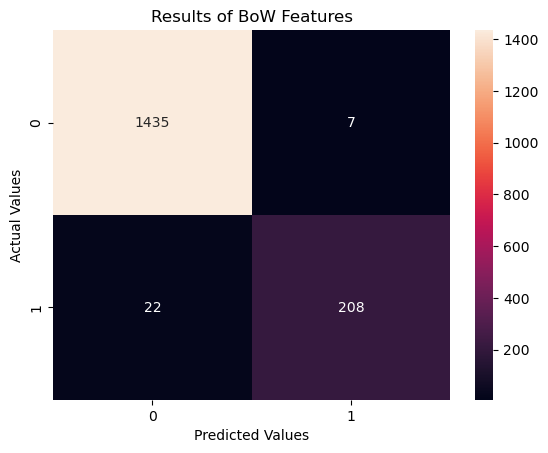

In [23]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

# Predict the test data
features_test_bow = count_vectorizer.transform(features_test)
target_test_pred_bow = model_grid.predict(features_test_bow)

# Model performance evaluation
print('\nPrecision: ', precision_score(target_test, target_test_pred_bow))
print('Recall: ', recall_score(target_test, target_test_pred_bow))
print('F1: ', f1_score(target_test, target_test_pred_bow))
confusion_matrix_bow = confusion_matrix(target_test, target_test_pred_bow)
cm_bow = sns.heatmap(confusion_matrix_bow, annot=True, fmt='d');
cm_bow.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of BoW Features');

#### The model correctly classified the vast majority of messages (values on the diagonal). 7 messages were incorrectly classified as spam (False Positive). This is offset by 22 unrecognized spam messages (False Negative).

In [24]:
#...also classification metrics via classification_report
print(classification_report(target_test, target_test_pred_bow, target_names=["Not spam", "Spam"]))

              precision    recall  f1-score   support

    Not spam       0.98      1.00      0.99      1442
        Spam       0.97      0.90      0.93       230

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



### Apply SVC to The TF-IDF Features
This time, use the features_train_tfidf feature matrix that we created with TfidfVectorizer to train model_grid.

In [25]:
# Fit the model
model_grid.fit(features_train_tfidf, target_train)

# Model score and best parameters
print('Best score:', model_grid.best_score_) 
print('Best C:', model_grid.best_estimator_.C) 
print('Best class_weight:', model_grid.best_estimator_.class_weight) 

Best score: 0.9272742975670031
Best C: 1
Best class_weight: balanced


We get an F1 value of about 0.93 for unbalanced class weights (balanced) and a C parameter of 1 when cross-validating. So the quality of the prediction in this case seems to be almost similar for both vectorization methods.

Let's see if this holds true for the test data.


Precision:  0.9427312775330396
Recall:  0.9304347826086956
F1:  0.936542669584245


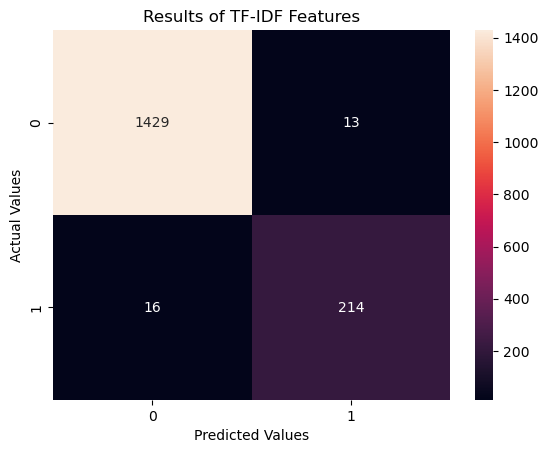

In [26]:
# Predict the test data 
features_test_tfidf = tfidf_vectorizer.transform(features_test)
target_test_pred_tfidf = model_grid.predict(features_test_tfidf)

# Model performance evaluation
print('\nPrecision: ', precision_score(target_test, target_test_pred_tfidf))
print('Recall: ', recall_score(target_test, target_test_pred_tfidf))
print('F1: ', f1_score(target_test, target_test_pred_tfidf))
confusion_matrix_tfidf = confusion_matrix(target_test, target_test_pred_tfidf)
cm_tfidf = sns.heatmap(confusion_matrix_tfidf, annot=True, fmt='d');
cm_tfidf.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of TF-IDF Features');

**Again, like with BoW features, the model correctly classified the vast majority of messages (values on the diagonal). 214 message are correctly detected as spam and 1429 are correctly classified as not spam. This time 13 text messages were incorrectly classified as spam. In return, 16 spam messages were not recognized by the model.**

**For the test messages, vectoring with TF-IDF has slightly better f1 (0.9365) score w.r.t. BoW f1 score (0.9348).**

In [27]:
# Classification report
print(classification_report(target_test, target_test_pred_tfidf, target_names=["Not Spam", "Spam"]))

              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1442
        Spam       0.94      0.93      0.94       230

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



# Next Action: Improvement Through Kernel Selection?
We can investigate if we can get better results with a different choice of kernel.

In [28]:
from sklearn.svm import SVC

# Instantiate the SVM model
model_kernel = SVC(random_state=1)

# Define the parameter search space for the grid search
search_space_kernel = {'C': [0.01, 0.1, 1, 10, 100], 
                       'kernel': ['poly', 'rbf'], 
                       'class_weight': [None, 'balanced']}

# Apply grid search
model_grid_kernel = GridSearchCV(estimator=model_kernel, 
                                 param_grid=search_space_kernel, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 scoring="f1")
# Fit model
model_grid_kernel.fit(features_train_tfidf,target_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'kernel': ['poly', 'rbf']},
             scoring='f1')

In [29]:
# Model score and best parameters
print('Best score:', model_grid_kernel.best_score_) 
print('Best C:', model_grid_kernel.best_estimator_.C) 
print('Best kernel:', model_grid_kernel.best_estimator_.kernel)
print('Best class_weight:', model_grid_kernel.best_estimator_.class_weight) 

Best score: 0.8856495658057085
Best C: 1
Best kernel: rbf
Best class_weight: balanced



Precision:  0.9901477832512315
Recall:  0.8739130434782608
F1:  0.9284064665127021


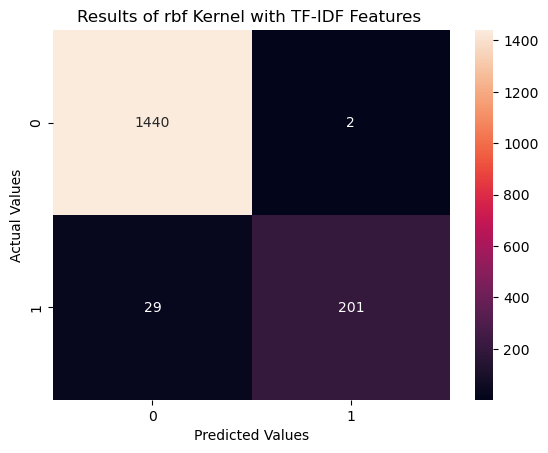

In [30]:
# Predict the test data 
target_test_pred_tfidf_kernel = model_grid_kernel.predict(features_test_tfidf)

# Model performance evaluation
print('\nPrecision: ', precision_score(target_test, target_test_pred_tfidf_kernel))
print('Recall: ', recall_score(target_test, target_test_pred_tfidf_kernel))
print('F1: ', f1_score(target_test, target_test_pred_tfidf_kernel))
confusion_matrix_tfidf_kernel = confusion_matrix(target_test, target_test_pred_tfidf_kernel)
cm_tfidf_kernel = sns.heatmap(confusion_matrix_tfidf_kernel, annot=True, fmt='d');
cm_tfidf_kernel.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of rbf Kernel with TF-IDF Features ');

We couldn't get better predictions with the 'poly' and 'rbf' kernels either. We use cross-validation to find the best model with an 'rbf' kernel. There is a F1 value of about 0.88 for a C of 1 with balanced class weights, which is less than LinearSVC model. Same performance of kernel model occurs with test data as can be seen from confusion matrix above!

# Thank you!
I hope this analysis was informative. Your comments are valuable in this matter, so please let me know :)

Cheers,

Amir